## LightGBMでトレーニングする

In [14]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np

# データの読み込みと確認
test_file_path = "/Users/hayakawakazue/Downloads/Nishika/apartments_price/train/train_processed.csv"
df = pd.read_csv(test_file_path, low_memory=False, encoding="utf-8")

# データ型の変換
df["取引時点"] = pd.to_numeric(df["取引時点"], errors='coerce')
df = df.fillna(df.median(numeric_only=True))

# カテゴリカル変数の変換
categorical_features = [
    "都道府県名", "地区名", "最寄駅：名称", "間取り", "建物の構造",
    "用途", "今後の利用目的", "都市計画", "改装", "取引の事情等"
]
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype("category")

# データの分割
df_train = df[df["取引時点"] < 2019.99]
df_val = df[df["取引時点"] >= 2019.99]

# 特徴量と目的変数の分割
col = "取引価格（総額）_log"
train_y = df_train[col]
train_x = df_train.drop(col, axis=1)

val_y = df_val[col]
val_x = df_val.drop(col, axis=1)

# LightGBM用のデータセットに変換
trains = lgb.Dataset(train_x, train_y, categorical_feature=categorical_features, free_raw_data=False)
valids = lgb.Dataset(val_x, val_y, categorical_feature=categorical_features, free_raw_data=False)

# ハイパーパラメータの設定
params = {
    "objective": "regression",
    "metric": "mae",
    "num_leaves": 3000,
    "max_depth": -1,
    "learning_rate": 0.1,
    "max_bin": 1024,
    "force_row_wise": True  # 行方向での並列処理を強制
}

# モデルのトレーニング
model = lgb.train(
    params,
    trains,
    valid_sets=[valids],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(50)
    ]
)

# 予測とMAEの計算
val_pred = model.predict(val_x)
mae_score = mae(val_y, val_pred)
print(f"MAE: {mae_score}")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 11974
[LightGBM] [Info] Number of data points in the train set: 625274, number of used features: 17
[LightGBM] [Info] Start training from score 7.216091
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l1: 0.0806738
[100]	valid_0's l1: 0.0798263
[150]	valid_0's l1: 0.0802627
[200]	valid_0's l1: 0.0805001
Early stopping, best iteration is:
[105]	valid_0's l1: 0.079796
MAE: 0.07979602657641355


## lightGBMが重視する特徴量を可視化する

          特徴量            重要度
7         建築年  141172.688257
6       面積（㎡）   81740.243366
1       都道府県名   53263.519467
3      最寄駅：名称   37573.937791
2         地区名   21833.548636
0     市区町村コード   20416.948502
14       取引時点   10218.652863
4   最寄駅：距離（分）    7672.219143
15         改装    5123.637642
5         間取り    4938.528460
16     取引の事情等    1530.964570
13     容積率（％）    1502.815340
11       都市計画     726.331073
12    建ぺい率（％）     502.551261
10    今後の利用目的     394.707251
8       建物の構造     165.305207
9          用途     160.775807


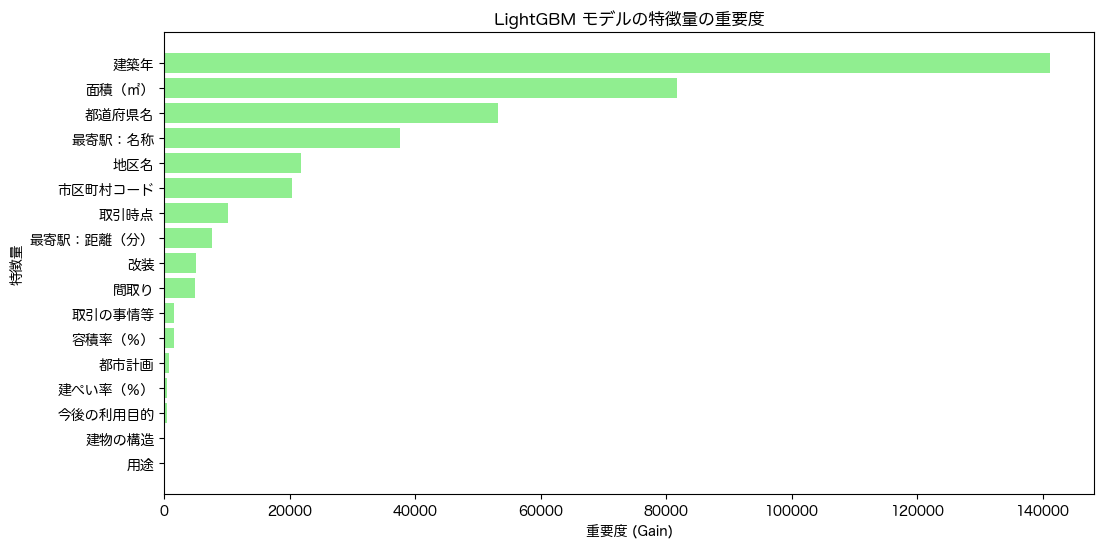

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# **モデルから特徴量名と重要度を取得**
feature_names = model.feature_name()  # モデルから直接特徴量の名前を取得
feature_importances = model.feature_importance(importance_type='gain')

# **特徴量とその重要度をDataFrameにまとめる**
importance_df = pd.DataFrame({
    '特徴量': feature_names,
    '重要度': feature_importances
})

# 重要度でソート
importance_df = importance_df.sort_values(by='重要度', ascending=False)

# **重要度を表示**
print(importance_df)

# **特徴量の重要度を視覚化する**
plt.figure(figsize=(12, 6))
plt.barh(importance_df['特徴量'], importance_df['重要度'], color='lightgreen')
plt.gca().invert_yaxis()  # 重要度の高い順に表示
plt.xlabel('重要度 (Gain)')
plt.ylabel('特徴量')
plt.title('LightGBM モデルの特徴量の重要度')
plt.show()


In [ ]:
##CatBoostでトレーニングする

In [19]:
import catboost as cb
from sklearn.metrics import mean_absolute_error as mae

# データの読み込みと確認
test_file_path = "/Users/hayakawakazue/Downloads/Nishika/apartments_price/train/train_processed.csv"
df = pd.read_csv(test_file_path, low_memory=False, encoding="utf-8")

# 目的変数の列名
target_column = "取引価格（総額）_log"
categorical_features = ['都道府県名', '地区名', '最寄駅：名称', '間取り', '建物の構造',
                        '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等']

# データを取引時点で分割
df_train = df[df["取引時点"] < 2019.99]
df_val = df[df["取引時点"] >= 2019.99]

# 特徴量と目的変数の抽出
X_train = df_train.drop(target_column, axis=1)
y_train = df_train[target_column]
X_val = df_val.drop(target_column, axis=1)
y_val = df_val[target_column]

# カテゴリカル変数を文字列に変換し、欠損値を 'missing' に置換
for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_val[col] = X_val[col].astype(str).fillna('missing')

# カテゴリカル列のインデックスを取得
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]

# CatBoostモデルの作成
model = cb.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,  # 学習率を少し下げることで安定化
    depth=8,
    loss_function='MAE',
    eval_metric='MAE',
    cat_features=cat_feature_indices,
    early_stopping_rounds=50
)

# モデルの学習
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=100
)

# 検証データでの予測
y_pred = model.predict(X_val)

# MAEの計算
mae_score = mae(y_val, y_pred)
print("MAE:", mae_score)

model.save_model("catboost_model.cbm")


0:	learn: 0.2516660	test: 0.2579102	best: 0.2579102 (0)	total: 573ms	remaining: 19m 5s
100:	learn: 0.0959664	test: 0.0988035	best: 0.0988035 (100)	total: 38.5s	remaining: 12m 3s
200:	learn: 0.0893011	test: 0.0913450	best: 0.0913450 (200)	total: 1m 19s	remaining: 11m 48s
300:	learn: 0.0859849	test: 0.0879163	best: 0.0879163 (300)	total: 2m	remaining: 11m 17s
400:	learn: 0.0838618	test: 0.0859879	best: 0.0859879 (400)	total: 2m 42s	remaining: 10m 47s
500:	learn: 0.0822670	test: 0.0846093	best: 0.0846093 (500)	total: 3m 24s	remaining: 10m 12s
600:	learn: 0.0810553	test: 0.0835454	best: 0.0835454 (600)	total: 4m 6s	remaining: 9m 34s
700:	learn: 0.0800035	test: 0.0827345	best: 0.0827345 (700)	total: 4m 49s	remaining: 8m 56s
800:	learn: 0.0791312	test: 0.0820522	best: 0.0820522 (800)	total: 5m 33s	remaining: 8m 19s
900:	learn: 0.0784191	test: 0.0814687	best: 0.0814687 (900)	total: 6m 18s	remaining: 7m 41s
1000:	learn: 0.0778132	test: 0.0810087	best: 0.0810087 (1000)	total: 7m 1s	remaining: 7

## catboostが重視する特徴量を可視化する

          特徴量        重要度
6       面積（㎡）  30.207216
7         建築年  19.689864
3      最寄駅：名称  12.856488
1       都道府県名  10.503524
0     市区町村コード   7.203636
4   最寄駅：距離（分）   4.703646
5         間取り   2.832369
2         地区名   2.539054
14       取引時点   2.379117
15         改装   1.578010
13     容積率（％）   1.422225
16     取引の事情等   1.183657
11       都市計画   0.991151
10    今後の利用目的   0.832890
8       建物の構造   0.621629
9          用途   0.298728
12    建ぺい率（％）   0.156796


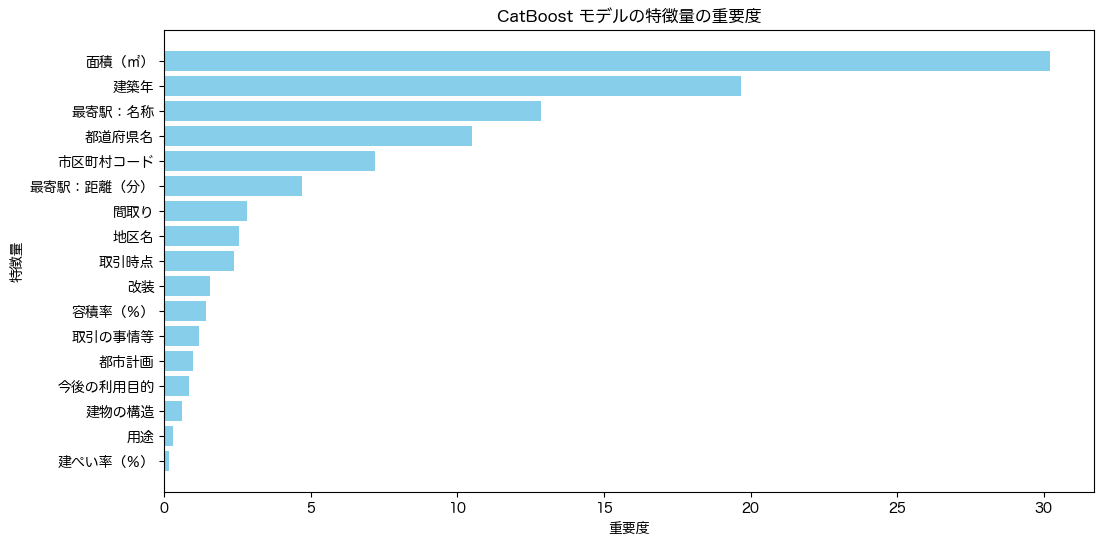

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# 学習済みモデルのロード
model = CatBoostRegressor()
model.load_model("catboost_model.cbm")

# 特徴量の名前を取得
feature_names = X_train.columns

# **特徴量の重要度を取得**
feature_importances = model.get_feature_importance()

# **特徴量とその重要度をDataFrameにまとめる**
importance_df = pd.DataFrame({
    '特徴量': feature_names,
    '重要度': feature_importances
})

# 重要度でソート
importance_df = importance_df.sort_values(by='重要度', ascending=False)

# **重要度を表示**
print(importance_df)

# **特徴量の重要度を視覚化する**
plt.figure(figsize=(12, 6))
plt.barh(importance_df['特徴量'], importance_df['重要度'], color='skyblue')
plt.gca().invert_yaxis()  # 重要度の高い順に表示
plt.xlabel('重要度')
plt.ylabel('特徴量')
plt.title('CatBoost モデルの特徴量の重要度')
plt.show()


## CatBoostモデルの学習曲線のプロット

dict_keys(['learn', 'validation'])


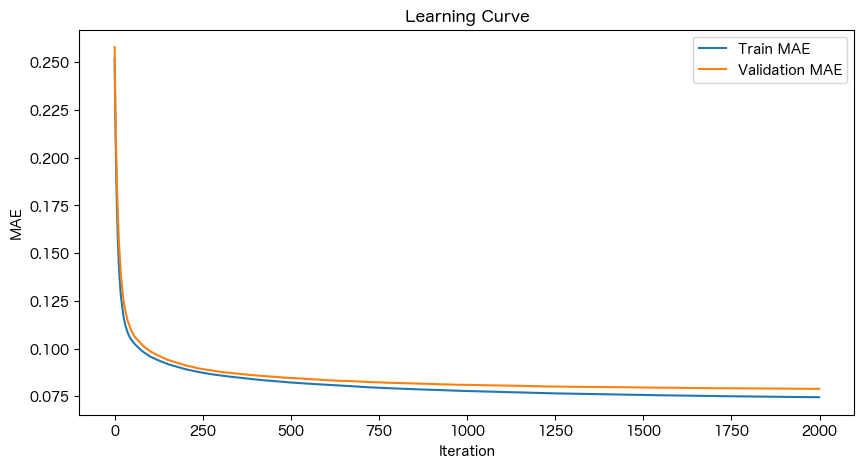

In [21]:
import matplotlib.pyplot as plt

# モデルの学習履歴を取得
eval_result = model.get_evals_result()

# 使用可能なキーを確認
print(eval_result.keys())  # キー名を確認

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(eval_result['learn']['MAE'], label='Train MAE')

# validationまたはvalidation_0に応じて修正
if 'validation_0' in eval_result:
    plt.plot(eval_result['validation_0']['MAE'], label='Validation MAE')
elif 'validation' in eval_result:
    plt.plot(eval_result['validation']['MAE'], label='Validation MAE')

plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.legend()
plt.title('Learning Curve')
plt.show()


## 実際のテストデータを予測する

In [22]:
import pandas as pd
from catboost import CatBoostRegressor

# categorical_features の定義（トレーニングと同じ列を指定）
categorical_features = [
    '都道府県名', '地区名', '最寄駅：名称', '間取り', '建物の構造',
    '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等'
]

# モデルのロード
model = CatBoostRegressor()
model.load_model("catboost_model.cbm")

# テストデータの読み込み
test_file_path = "/Users/hayakawakazue/Downloads/Nishika/apartments_price/test/original_data/test_proceeded.csv"
df_test_processed = pd.read_csv(test_file_path)

# **ID列が存在するか確認**
if 'ID' not in df_test_processed.columns:
    raise ValueError("テストデータにID列が必要です。")

# トレーニングデータの列順に揃える
train_columns = [
    '市区町村コード', '都道府県名', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
    '間取り', '面積（㎡）', '建築年', '建物の構造', '用途',
    '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）',
    '取引時点', '改装', '取引の事情等'
]
df_test_processed = df_test_processed.set_index('ID')  # IDをインデックスに設定

# カテゴリカル変数を文字列型に変換し、NaNを 'missing' に置換
for col in categorical_features:
    if col in df_test_processed.columns:
        df_test_processed[col] = df_test_processed[col].astype(str).fillna('missing')

# 予測を実行
predict = model.predict(df_test_processed)

# **提出用のDataFrameを作成（IDと予測結果を含む）**
submission = pd.DataFrame({
    "ID": df_test_processed.index,  # インデックスからIDを取得
    "取引価格（総額）_log": predict
})

# **提出用のCSVとして保存**
submission.to_csv("submit_submission_1025.csv", index=False)

print("予測結果をsubmit_submission_1025.csvに保存しました。")


予測結果をsubmit_submission_1025.csvに保存しました。
